کتابخانه های مورد نیاز

دانلود دیتاست مورد استفاده:   https://www.mediafire.com/file/j03djpy140rno4d/data.rar/file

In [64]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

from PIL import Image 
import random
import tensorflow as tf  


به جهت ثابت نگه داشتن دقت

In [65]:
seed_value = 42
np.random.seed(seed_value)  
random.seed(seed_value)  
tf.random.set_seed(seed_value) 

وارد کردن دیتاست

In [66]:
data_dir = "data"  
categories = os.listdir(data_dir) 

داده‌ها و برچسب‌ها 

In [67]:
images = []
labels = []

فرمت‌های تصویری پشتیبانی‌شده

In [68]:
valid_formats = ('.jpg', '.png', '.gif', '.jpeg')

تعداد تصاویر در هر پوشه

In [69]:
for category in categories:  
    category_path = os.path.join(data_dir, category)
    image_count = len([file for file in os.listdir(category_path) if file.lower().endswith(valid_formats)])
    print(f"Number_Images_'{category}' : {image_count} images.")


Number_Images_'Angry' : 86 images.
Number_Images_'Happy' : 100 images.
Number_Images_'Sad' : 79 images.


تعداد فرمت های تصاویر برای هر احساس

In [70]:
for category in categories:
    category_path = os.path.join(data_dir, category)
    format_count = {ext: 0 for ext in valid_formats}
    
    for file in os.listdir(category_path):
        file_lower = file.lower()
        for ext in valid_formats:
            if file_lower.endswith(ext):
                format_count[ext] += 1

    print(f"Emotion: '{category}'")
    for ext, count in format_count.items():
        print(f"  {ext}:  {count}")


Emotion: 'Angry'
  .jpg:  67
  .png:  14
  .gif:  0
  .jpeg:  5
Emotion: 'Happy'
  .jpg:  80
  .png:  8
  .gif:  0
  .jpeg:  12
Emotion: 'Sad'
  .jpg:  69
  .png:  4
  .gif:  1
  .jpeg:  5


تغییر سایز

In [71]:
img_size = 32

بارگذاری و پردازش تصاویر

In [72]:
for label, category in enumerate(categories):  
    category_path = os.path.join(data_dir, category)  
    for file in os.listdir(category_path):  
        if file.lower().endswith(valid_formats):  
            file_path = os.path.join(category_path, file)  
            try:  
                if file.lower().endswith('.gif'):  
                    img = Image.open(file_path)  # برای لحاظ gif  
                    img = img.convert('RGB')  # تبدیل به  RGB  
                    img_resized = img.resize((img_size, img_size), Image.LANCZOS)  # تغییر اندازه با آنتی‌الیزینگ  
                    img_resized = cv2.cvtColor(np.array(img_resized), cv2.COLOR_RGB2BGR)  # تبدیل به  OpenCV  
                else:  
                    img = cv2.imread(file_path, cv2.IMREAD_COLOR)  # بارگذاری سایر تصاویر با OpenCV  
                    if img is not None:  
                        img_resized = cv2.resize(img, (img_size, img_size))  

                images.append(img_resized)  # اضافه کردن تصویر تغییر اندازه داده شده  
                labels.append(label) 
            except Exception as e:  
                print(f"Error processing {file_path}: {e}")

 و نرمال سازی تبدیل به آرایه numpy 

In [73]:
images = np.array(images) / 255.0  
labels = np.array(labels)

ورود لیبل ها به صورت one hot

In [74]:
labels = to_categorical(labels, num_classes=len(categories))

تقسیم داده‌های آموزشی و آزمایشی

In [75]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

تغییر شکل تصاویر برای ورود به RNN

In [76]:
X_train = X_train.reshape(X_train.shape[0], 1, img_size * img_size * 3)  
X_test = X_test.reshape(X_test.shape[0], 1, img_size * img_size * 3)

In [77]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (212, 1, 3072)
Shape of y_train: (212, 3)


یکسان سازی شکل 

In [78]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

ساخت مدل RNN_LSTM

In [79]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, img_size * img_size * 3), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(categories), activation='softmax'))


کامپایل مدل

In [80]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

حذف بعد اضافی از y_train و y_test

In [81]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

print(f"y_train shape after reshape: {y_train.shape}")

y_train shape after reshape: (212, 3)


آموزش مدل

In [82]:
lr_scheduler = ReduceLROnPlateau( monitor='val_loss', factor=0.5, patience=5, verbose=1 )  
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=90, batch_size=32, callbacks=[lr_scheduler])

Epoch 1/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.3477 - loss: 1.2585 - val_accuracy: 0.3774 - val_loss: 1.1894 - learning_rate: 0.0010
Epoch 2/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3576 - loss: 1.2061 - val_accuracy: 0.3962 - val_loss: 1.1479 - learning_rate: 0.0010
Epoch 3/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3287 - loss: 1.1162 - val_accuracy: 0.3962 - val_loss: 1.1135 - learning_rate: 0.0010
Epoch 4/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3087 - loss: 1.1689 - val_accuracy: 0.4151 - val_loss: 1.0961 - learning_rate: 0.0010
Epoch 5/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3882 - loss: 1.1068 - val_accuracy: 0.3962 - val_loss: 1.0944 - learning_rate: 0.0010
Epoch 6/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4034 - loss: 1.0912 - val_accuracy: 0.3962 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 7/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3533 - loss: 1.1295 - val_accuracy: 0.4151

ارزیابی مدل

In [83]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6464 - loss: 0.9210
Test Accuracy: 64.15%


رسم نمودار

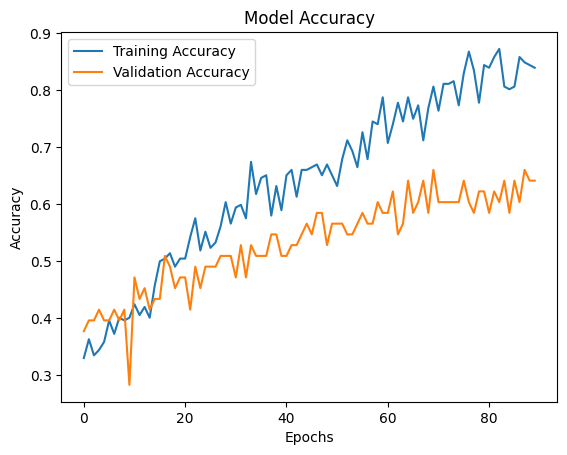

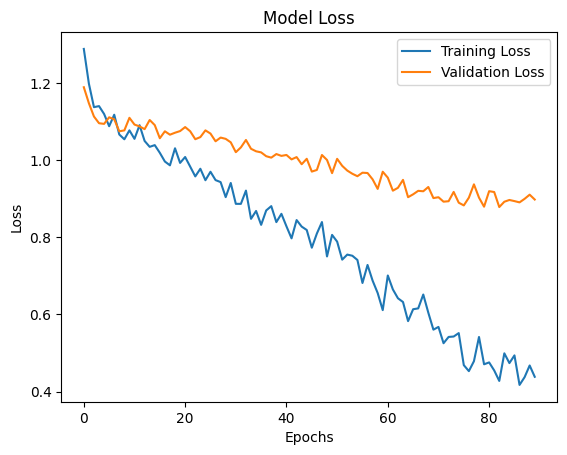

In [84]:
# accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()